# BT4012 Fraud Analytics Project – Enhanced Baseline Notebook

This notebook implements an improved fraud detection pipeline for the BT4012 group project.

It is structured to align with the recommended report flow:

1. Data Loading & Understanding  
2. Exploratory Data Analysis (EDA) - in a separate notebook
3. Feature Engineering  
4. Data Preprocessing & Handling Class Imbalance  
5. Model Training with Cross-Validation  
6. Model Comparison  
7. Feature Importance & Business Insights  

> **Datasets used:** `loan_applications.csv`, `transactions.csv`

## Imports and Configs

In [39]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold, train_test_split, 
    RandomizedSearchCV, GridSearchCV
)
from scipy.stats import uniform, randint

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    classification_report, precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import Booster

# Display settings
pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

In [40]:
# Configuration
RANDOM_STATE = 42
N_SPLITS = 5
DEEP_SEARCH_ITER = 50

## Load Datasets

In [41]:
data_dir = "."
loan_path = os.path.join(data_dir, "loan_applications.csv")
txn_path = os.path.join(data_dir, "transactions.csv")

print("Loading datasets...")
loan_df = pd.read_csv(loan_path)
txn_df = pd.read_csv(txn_path)

# Drop columns identified for removal/data leakage prevention
cols_to_drop = ['loan_status', 'residential_address', 'fraud_type', 'application_id', 'customer_id', 'transaction_id']
loan_df_model = loan_df.drop(columns=[col for col in cols_to_drop if col in loan_df.columns and col != 'customer_id'])

Loading datasets...


In [42]:
loan_rows = loan_df.shape
txn_rows = txn_df.shape
print("Shape of Loan Applications dataset:", loan_rows)
print("Shape of Transactions dataset:", txn_rows)

Shape of Loan Applications dataset: (50000, 21)
Shape of Transactions dataset: (50000, 16)


In [43]:
display(loan_df.head())
display(txn_df.head())

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


## Feature Engineering - Transactions

In [44]:
# Convert transaction_date to datetime
txn_df["transaction_date"] = pd.to_datetime(txn_df["transaction_date"], errors="coerce")

# Sort by customer & time
txn_df = txn_df.sort_values(["customer_id", "transaction_date"])

# Calculate transaction frequency for each customer over different time windows
txn_df['txn_day'] = txn_df['transaction_date'].dt.day
txn_df['txn_week'] = txn_df['transaction_date'].dt.isocalendar().week
txn_df['txn_month'] = txn_df['transaction_date'].dt.month

# Calculate time since last transaction
# This will be aggregated to 'mean_time_between_txns' etc.
txn_df['txn_time_diff'] = txn_df.groupby('customer_id')['transaction_date'].diff().dt.total_seconds()

# Hour of the day
txn_df['txn_hour'] = txn_df['transaction_date'].dt.hour

# Calculate rolling mean and standard deviation for transaction amounts over a 7-day window
txn_df['txn_amount_rolling_mean_7txn'] = txn_df.groupby('customer_id')['transaction_amount'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
txn_df['txn_amount_rolling_std_7txn'] = txn_df.groupby('customer_id')['transaction_amount'].rolling(7, min_periods=1).std().reset_index(0, drop=True)

# Identifying outliers (e.g., 95th percentile transactions)
txn_df['txn_amount_outlier'] = txn_df['transaction_amount'] > txn_df['transaction_amount'].quantile(0.95)

In [45]:
# Basic numeric aggregations per customer
txn_amount_agg = txn_df.groupby("customer_id")["transaction_amount"].agg(
    ["sum", "mean", "max", "min", "std", "count"]
).rename(
    columns={
        "sum": "txn_amount_sum",
        "mean": "txn_amount_mean",
        "max": "txn_amount_max",
        "min": "txn_amount_min",
        "std": "txn_amount_std",
        "count": "txn_count",
    }
)
txn_amount_agg["txn_amount_std"] = txn_amount_agg["txn_amount_std"].fillna(0)


# Transaction type counts per customer
txn_type_counts = (
    txn_df
    .pivot_table(
        index="customer_id",
        columns="transaction_type",
        values="transaction_id",
        aggfunc="count",
        fill_value=0,
    )
)
txn_type_counts.columns = [f"txn_type_{c}_count" for c in txn_type_counts.columns]


# Merchant category counts per customer
merchant_cat_counts = (
    txn_df
    .pivot_table(
        index="customer_id",
        columns="merchant_category",
        values="transaction_id",
        aggfunc="count",
        fill_value=0,
    )
)
merchant_cat_counts.columns = [f"merchant_cat_{c}_count" for c in merchant_cat_counts.columns]


# Aggregate the time-based features
time_based_features = txn_df.groupby('customer_id').agg(
    # Time between transactions
    mean_time_between_txn_sec=('txn_time_diff', 'mean'),
    std_time_between_txn_sec=('txn_time_diff', 'std'),
    max_time_between_txn_sec=('txn_time_diff', 'max'),
    
    # Time of day
    mean_txn_hour=('txn_hour', 'mean'),
    std_txn_hour=('txn_hour', 'std'),
    
    # Rolling features (we take the mean of the rolling values)
    mean_rolling_amt_7txn=('txn_amount_rolling_mean_7txn', 'mean'),
    mean_rolling_std_7txn=('txn_amount_rolling_std_7txn', 'mean'),
    
    # Outliers
    num_outlier_txns=('txn_amount_outlier', 'sum'),
)

# Combine all transaction-level features
all_txn_aggs = [
    txn_amount_agg,
    txn_type_counts,
    merchant_cat_counts,
    time_based_features # Add the new features
]

txn_features = pd.concat(all_txn_aggs, axis=1)

print("Engineered transaction feature shape:", txn_features.shape)
display(txn_features.head())

Engineered transaction feature shape: (18318, 36)


,txn_amount_sum,txn_amount_mean,txn_amount_max,txn_amount_min,txn_amount_std,txn_count,txn_type_ATM Withdrawal_count,txn_type_Bill Payment_count,txn_type_Credit Card_count,txn_type_Debit Card_count,txn_type_Deposit_count,txn_type_EMI Payment_count,txn_type_Fund Transfer_count,txn_type_Loan Disbursement_count,txn_type_Net Banking_count,txn_type_UPI_count,merchant_cat_Cash Withdrawal_count,merchant_cat_Dining_count,merchant_cat_Education_count,merchant_cat_Electronics_count,merchant_cat_Entertainment_count,merchant_cat_Financial Services_count,merchant_cat_Fuel_count,merchant_cat_Groceries_count,merchant_cat_Healthcare_count,merchant_cat_Online Shopping_count,merchant_cat_Travel_count,merchant_cat_Utilities_count,mean_time_between_txn_sec,std_time_between_txn_sec,max_time_between_txn_sec,mean_txn_hour,std_txn_hour,mean_rolling_amt_7txn,mean_rolling_std_7txn,num_outlier_txns
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CUST100000,2700.0,1350.000000,2500.0,200.0,1626.345597,2,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,417360.0,NaN,417360.0,17.000000,2.828427,775.000000,1626.345597,0
CUST100001,23200.0,7733.333333,15200.0,1400.0,6969.457176,3,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,905670.0,6.801377e+05,1386600.0,18.000000,1.000000,4377.777778,5323.206219,1
CUST100003,13200.0,4400.000000,10100.0,1200.0,4948.737213,3,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1043910.0,1.047890e+06,1784880.0,10.333333,6.110101,2616.666667,2721.855980,0
CUST100005,14700.0,7350.000000,10500.0,4200.0,4454.772721,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,231180.0,NaN,231180.0,7.000000,5.656854,5775.000000,4454.772721,0
CUST100006,7600.0,2533.333333,4500.0,200.0,2173.323108,3,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,1,747090.0,5.334272e+05,1124280.0,12.666667,3.785939,1694.444444,2606.941134,0


## Feature Engineering – Loan Applications

In [46]:
loan_df.columns

Index(['application_id', 'customer_id', 'application_date', 'loan_type',
       'loan_amount_requested', 'loan_tenure_months', 'interest_rate_offered',
       'purpose_of_loan', 'employment_status', 'monthly_income', 'cibil_score',
       'existing_emis_monthly', 'debt_to_income_ratio',
       'property_ownership_status', 'residential_address', 'applicant_age',
       'gender', 'number_of_dependents', 'loan_status', 'fraud_flag',
       'fraud_type'],
      dtype='object')

In [47]:
loan_df.head()

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


In [48]:
loan_fe_df = loan_df.copy()

# Convert application_date to datetime
loan_fe_df["application_date"] = pd.to_datetime(loan_fe_df["application_date"], errors="coerce")

# Numeric ratios – standard in credit/fraud scoring
loan_fe_df["loan_to_income_ratio"] = loan_fe_df["loan_amount_requested"] / (loan_fe_df["monthly_income"] + 1e-9)

# Simple age buckets (could be useful for non-linear effects)
loan_fe_df["age_bucket"] = pd.cut(
    loan_fe_df["applicant_age"],
    bins=[0, 25, 35, 45, 60, 100],
    labels=["<=25", "26-35", "36-45", "46-60", "60+"],
    include_lowest=True,
)

def extract_region(addr):
    if isinstance(addr, str) and "," in addr:
        return addr.split(",")[-1].strip()
    return "Unknown"

loan_fe_df["region"] = loan_fe_df["residential_address"].apply(extract_region)

display(loan_fe_df[[
    "application_id", "customer_id", "loan_amount_requested",
    "monthly_income", "loan_to_income_ratio", "debt_to_income_ratio",
    "applicant_age", "age_bucket", "region"
]].head())

,application_id,customer_id,loan_amount_requested,monthly_income,loan_to_income_ratio,debt_to_income_ratio,applicant_age,age_bucket,region
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,604000.0,34700.0,17.406340,3.17,28,26-35,918055
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,100000.0,51600.0,1.937984,0.00,44,36-45,909564
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,431000.0,14800.0,29.121622,31.08,56,46-60,797564
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,324000.0,28800.0,11.250000,13.89,27,26-35,097184
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,100000.0,43900.0,2.277904,2.51,50,46-60,775386


In [49]:
loan_fe_df.head()

,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type,loan_to_income_ratio,age_bucket,region
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN,17.406340,26-35,918055
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN,1.937984,36-45,909564
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN,29.121622,46-60,797564
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN,11.250000,26-35,097184
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN,2.277904,46-60,775386


## Merge Loan & Transaction Features

In [50]:
# Index transaction features by customer_id for merging
txn_features_reset = txn_features.reset_index()

# Left-join: keep all loan applications
full_df = loan_fe_df.merge(
    txn_features_reset,
    on="customer_id",
    how="left",
)

print("Full merged dataset shape:", full_df.shape)
display(full_df.head())

# Check missingness of engineered transaction features
txn_feature_cols = [c for c in full_df.columns if c.startswith(("txn_", "merchant_cat_"))]
print("\nMissingness in transaction-derived features:")
display(full_df[txn_feature_cols].isna().mean().sort_values(ascending=False).head(10))

Full merged dataset shape: (50000, 60)


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type,loan_to_income_ratio,age_bucket,region,txn_amount_sum,txn_amount_mean,txn_amount_max,txn_amount_min,txn_amount_std,txn_count,txn_type_ATM Withdrawal_count,txn_type_Bill Payment_count,txn_type_Credit Card_count,txn_type_Debit Card_count,txn_type_Deposit_count,txn_type_EMI Payment_count,txn_type_Fund Transfer_count,txn_type_Loan Disbursement_count,txn_type_Net Banking_count,txn_type_UPI_count,merchant_cat_Cash Withdrawal_count,merchant_cat_Dining_count,merchant_cat_Education_count,merchant_cat_Electronics_count,merchant_cat_Entertainment_count,merchant_cat_Financial Services_count,merchant_cat_Fuel_count,merchant_cat_Groceries_count,merchant_cat_Healthcare_count,merchant_cat_Online Shopping_count,merchant_cat_Travel_count,merchant_cat_Utilities_count,mean_time_between_txn_sec,std_time_between_txn_sec,max_time_between_txn_sec,mean_txn_hour,std_txn_hour,mean_rolling_amt_7txn,mean_rolling_std_7txn,num_outlier_txns
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN,17.406340,26-35,918055,13700.0,6850.000000,8800.0,4900.0,2757.716447,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,352140.0,NaN,352140.0,11.00,1.414214,5875.000000,2757.716447,0.0
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN,1.937984,36-45,909564,18700.0,4675.000000,9800.0,900.0,3730.393187,4.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,615140.0,296614.369847,787020.0,14.50,9.327379,4010.416667,2043.339302,0.0
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN,29.121622,46-60,797564,13100.0,3275.000000,7600.0,300.0,3607.746296,4.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,634540.0,951735.146141,1732440.0,19.75,5.852350,4672.916667,3069.304867,0.0
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN,11.250000,26-35,097184,2900.0,1450.000000,2200.0,700.0,1060.660172,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1597800.0,NaN,1597800.0,12.00,8.485281,1825.000000,1060.660172,0.0
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN,2.277904,46-60,775386,35600.0,11866.666667,18500.0,3300.0,7782.244749,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,63600.0,26643.783515,82440.0,14.00,7.000000,11405.555556,7603.432976,1.0



Missingness in transaction-derived features:


txn_amount_sum                           0.08406
txn_amount_mean                          0.08406
merchant_cat_Travel_count                0.08406
merchant_cat_Online Shopping_count       0.08406
merchant_cat_Healthcare_count            0.08406
merchant_cat_Groceries_count             0.08406
merchant_cat_Fuel_count                  0.08406
merchant_cat_Financial Services_count    0.08406
merchant_cat_Entertainment_count         0.08406
merchant_cat_Electronics_count           0.08406
dtype: float64

## Preprocessing & Class Imbalance Handling

In [51]:
# Target
y = full_df["fraud_flag"].astype(int)

# Columns to drop
drop_cols = [
    "fraud_flag",
    "fraud_type",
    "application_id",
    "customer_id",
    "residential_address",
    "application_date",
    "loan_status",
    "region"
]

X = full_df.drop(columns=[c for c in drop_cols if c in full_df.columns])

# Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

# Imputation before pipeline
txn_prefixes = ("txn_", "merchant_cat_", "mean_", "std_", "max_", "num_")
for col in numeric_cols:
    if col.startswith(txn_prefixes):
        X[col] = X[col].fillna(0)

Numeric features: 46
Categorical features: 6


In [52]:
# Class imbalance – compute positive weight
counter = Counter(y)
neg, pos = counter[0], counter[1]
print("\nClass distribution:", counter)
if pos > 0:
    scale_pos_weight = neg / pos
else:
    scale_pos_weight = 1.0
print("scale_pos_weight (for XGB/LGBM):", scale_pos_weight)

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


Class distribution: Counter({0: 48974, 1: 1026})
scale_pos_weight (for XGB/LGBM): 47.732943469785575


## Train/Val Split (Baseline)

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train size:", X_train.shape, "Valid size:", X_valid.shape)

# Baseline logistic regression with class_weight
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg),
])

log_reg_clf.fit(X_train, y_train)
y_valid_proba = log_reg_clf.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

print("\nBaseline Logistic Regression (hold-out)")
print("AUC:", roc_auc_score(y_valid, y_valid_proba))
print("Precision:", precision_score(y_valid, y_valid_pred, zero_division=0))
print("Recall:", recall_score(y_valid, y_valid_pred, zero_division=0))
print("F1:", f1_score(y_valid, y_valid_pred, zero_division=0))

Train size: (40000, 52) Valid size: (10000, 52)

Baseline Logistic Regression (hold-out)
AUC: 0.6200012450354213
Precision: 0.03072153325817362
Recall: 0.5317073170731708
F1: 0.05808686384225953


## Default Parameter Models

In [54]:
# Helper function to evaluate models
def evaluate(model, name):
    y_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    print(f"\n==== {name} ====")
    print("AUC:", roc_auc_score(y_valid, y_proba))
    print("Precision:", precision_score(y_valid, y_pred, zero_division=0))
    print("Recall:", recall_score(y_valid, y_pred, zero_division=0))
    print("F1:", f1_score(y_valid, y_pred, zero_division=0))

In [55]:
# 1. Logistic Regression
log_reg = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])
log_reg.fit(X_train, y_train)
evaluate(log_reg, "Logistic Regression")


# 2. Random Forest
rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])
rf.fit(X_train, y_train)
evaluate(rf, "Random Forest")


# 3. XGBoost
xgb = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=1,
        colsample_bytree=1,
        eval_metric="logloss",
        random_state=RANDOM_STATE
    ))
])
xgb.fit(X_train, y_train)
evaluate(xgb, "XGBoost")


==== Logistic Regression ====
AUC: 0.6200012450354213
Precision: 0.03072153325817362
Recall: 0.5317073170731708
F1: 0.05808686384225953

==== Random Forest ====
AUC: 0.948171665483883
Precision: 1.0
Recall: 0.14634146341463414
F1: 0.2553191489361702

==== XGBoost ====
AUC: 0.781565009524521
Precision: 1.0
Recall: 0.024390243902439025
F1: 0.047619047619047616


## Hyperparameter Tuning

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Logistic Regression

In [ ]:
print("Starting hyperparameter tuning...")

# Logistic Regression
print("Tuning LogisticRegression...")
log_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
])
log_reg_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
}
log_reg_search = GridSearchCV(log_reg_pipe, log_reg_params, cv=skf, scoring='f1', n_jobs=1)
log_reg_search.fit(X_train, y_train) 
print(f"LogReg Best F1: {log_reg_search.best_score_:.4f}")
print(f"LogReg Best Params: {log_reg_search.best_params_}\n")


Starting hyperparameter tuning...
Tuning LogisticRegression...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

LogReg Best F1: 0.0606
LogReg Best Params: {'model__C': 0.1, 'model__solver': 'liblinear'}



### Random Forest

In [ ]:
# Random Forest (RandomizedSearch)
print("Tuning RandomForest...")
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
])
rf_params = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 11),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', 0.5]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=10, cv=skf, scoring='f1', n_jobs=1, random_state=RANDOM_STATE)
rf_search.fit(X_train, y_train)
print(f"RF Best F1: {rf_search.best_score_:.4f}")
print(f"RF Best Params: {rf_search.best_params_}\n")

Tuning RandomForest...
RF Best F1: 0.4591
RF Best Params: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 199}



### XGBoost

In [ ]:
# XGBoost (RandomizedSearch)
if XGBClassifier is not None:
    print("Tuning XGBoost...")
    xgb_pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(scale_pos_weight=scale_pos_weight, objective="binary:logistic", eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1))
    ])
    xgb_params = {
        'model__n_estimators': randint(100, 600),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 8),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.7, 0.3)
    }
    xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=10, cv=skf, scoring='f1', n_jobs=1, random_state=RANDOM_STATE)
    xgb_search.fit(X_train, y_train)
    print(f"XGB Best F1: {xgb_search.best_score_:.4f}")
    print(f"XGB Best Params: {xgb_search.best_params_}\n")
else:
    print("XGBoost not available, skipping tuning.")

print("--- Tuning Complete ---")

# --- Store the best parameters automatically ---
best_model_params = {
    "LogisticRegression": {k.split('__')[1]: v for k, v in log_reg_search.best_params_.items()},
    "RandomForest": {k.split('__')[1]: v for k, v in rf_search.best_params_.items()}
}
if XGBClassifier is not None:
    best_model_params["XGBoost"] = {k.split('__')[1]: v for k, v in xgb_search.best_params_.items()}

print("\nBest parameters have been saved to 'best_model_params' dictionary:")
print(best_model_params)

Tuning XGBoost...
XGB Best F1: 0.7165
XGB Best Params: {'model__colsample_bytree': np.float64(0.7692681476866446), 'model__learning_rate': np.float64(0.05820509320520235), 'model__max_depth': 6, 'model__n_estimators': 554, 'model__subsample': np.float64(0.8829989973347863)}

--- Tuning Complete ---

Best parameters have been saved to 'best_model_params' dictionary:
{'LogisticRegression': {'C': 0.1, 'solver': 'liblinear'}, 'RandomForest': {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 199}, 'XGBoost': {'colsample_bytree': np.float64(0.7692681476866446), 'learning_rate': np.float64(0.05820509320520235), 'max_depth': 6, 'n_estimators': 554, 'subsample': np.float64(0.8829989973347863)}}


## CV & Model Comparison

In [ ]:
models = {}

# Logistic Regression
models["LogisticRegression"] = LogisticRegression(
    **best_model_params["LogisticRegression"], 
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# Random Forest
models["RandomForest"] = RandomForestClassifier(
    **best_model_params["RandomForest"], 
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# XGBoost
models["XGBoost"] = XGBClassifier(
	**best_model_params["XGBoost"], 
	scale_pos_weight=scale_pos_weight,
	objective="binary:logistic",
	eval_metric="logloss",
	random_state=RANDOM_STATE,
	n_jobs=1,
)

In [ ]:
# Store OOF probabilities for each model
oof_predictions = {}

for model_name, base_clf in models.items():
    print(f"\n==== {model_name} ====")
    oof_proba = np.zeros(len(X), dtype=float) # Note: OOF is on FULL X, y

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Fold {fold}")
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = Pipeline(steps=[("preprocess", preprocessor), ("model", base_clf)])
        clf.fit(X_tr, y_tr)
        proba_val = clf.predict_proba(X_val)[:, 1]
        oof_proba[val_idx] = proba_val

    oof_predictions[model_name] = oof_proba

# Evaluate models by finding the BEST threshold for F1
print("\nCross-validated model performance (OOF with Optimal Threshold):")
results = []

for model_name, proba in oof_predictions.items():
    auc = roc_auc_score(y, proba)
    precisions, recalls, thresholds = precision_recall_curve(y, proba)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    best_precision = precisions[best_f1_idx]
    best_recall = recalls[best_f1_idx]

    results.append({
        "model": model_name,
        "auc": auc,
        "best_f1": best_f1,
        "best_threshold": best_threshold,
        "precision_at_best_f1": best_precision,
        "recall_at_best_f1": best_recall,
    })

results_df = pd.DataFrame(results).sort_values("best_f1", ascending=False)
display(results_df)


==== LogisticRegression ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== RandomForest ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== XGBoost ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

Cross-validated model performance (OOF with Optimal Threshold):


,model,auc,best_f1,best_threshold,precision_at_best_f1,recall_at_best_f1
2,XGBoost,0.944700,0.815360,0.469365,0.885714,0.755361
1,RandomForest,0.949893,0.792490,0.294978,0.803607,0.781676
0,LogisticRegression,0.634877,0.085416,0.675994,0.055687,0.183236


## Plotting Results

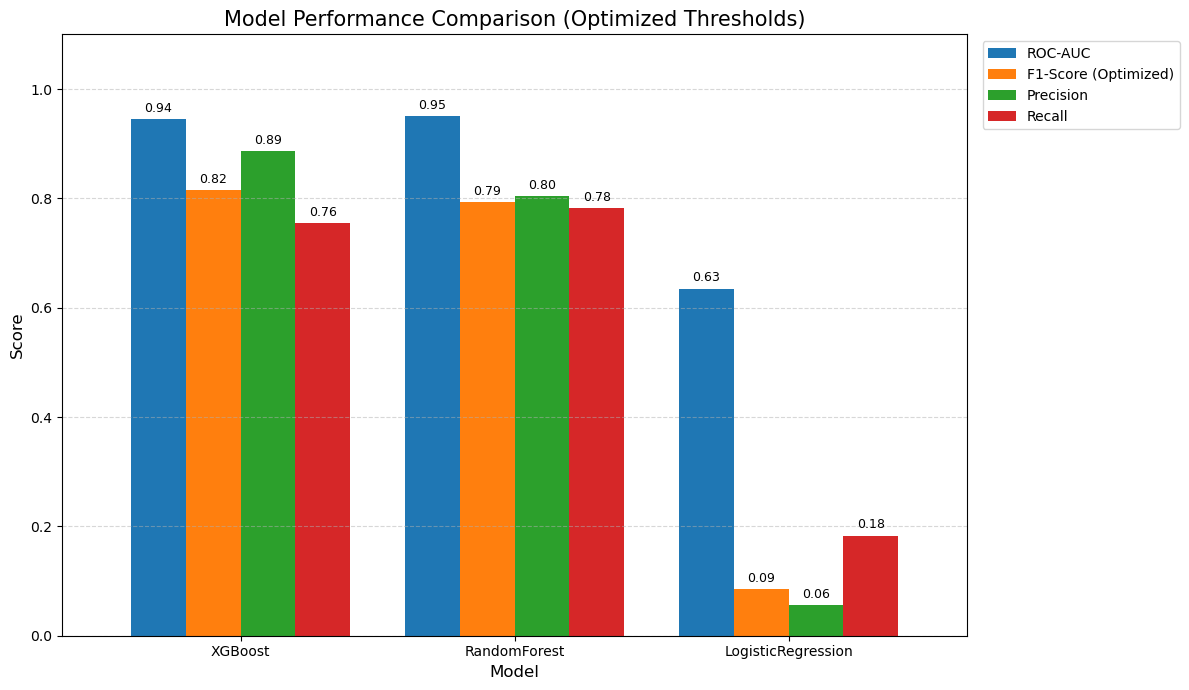

In [ ]:
def plot_model_performance(results_df):
    """
    Plots model comparison based on the results DataFrame.
    """
    # Set 'model' as index for easy plotting
    if 'model' in results_df.columns:
        df_plot = results_df.set_index('model')
    else:
        df_plot = results_df.copy()

    # Metrics to plot (from our improved evaluation step)
    metrics = ['auc', 'best_f1', 'precision_at_best_f1', 'recall_at_best_f1']
    
    # Rename columns for cleaner legend
    rename_map = {
        'auc': 'ROC-AUC',
        'best_f1': 'F1-Score (Optimized)',
        'precision_at_best_f1': 'Precision',
        'recall_at_best_f1': 'Recall'
    }
    
    # Filter and rename
    df_plot = df_plot[metrics].rename(columns=rename_map)
    
    # Plotting
    ax = df_plot.plot(kind='bar', figsize=(12, 7), width=0.8)
    
    plt.title('Model Performance Comparison (Optimized Thresholds)', fontsize=15)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 1.1)  # Extra space for labels
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add text labels on bars
    for p in ax.patches:
        # Ignore zero-height bars (if any)
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', 
                       fontsize=9, xytext=(0, 3), 
                       textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Call the function directly with the results DataFrame
plot_model_performance(results_df)

## Fit Final Model & Feature Importances

In [ ]:
# Train Best Model on Full Data
best_model_name = results_df.iloc[0]["model"]
print(f"Best model identified: {best_model_name}")

final_base_clf = models[best_model_name]
final_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", final_base_clf),
])

print(f"Training final {best_model_name} model on all data...")
final_clf.fit(X, y)
print("Training complete.")

Best model identified: XGBoost
Training final XGBoost model on all data...
Training complete.


In [ ]:
def plot_feature_importance(model, title, feature_names, n_features=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        return

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(n_features)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_feature_names(fitted_preprocessor):
    num_features = numeric_cols
    cat_ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = cat_ohe.get_feature_names_out(categorical_cols)
    return np.concatenate([num_features, cat_features])


---- LogisticRegression: Top 20 Features ----


/var/folders/nt/lksf3v5916q60xttk_z7182m0000gn/T/ipykernel_46113/3305877514.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top20, palette="viridis")


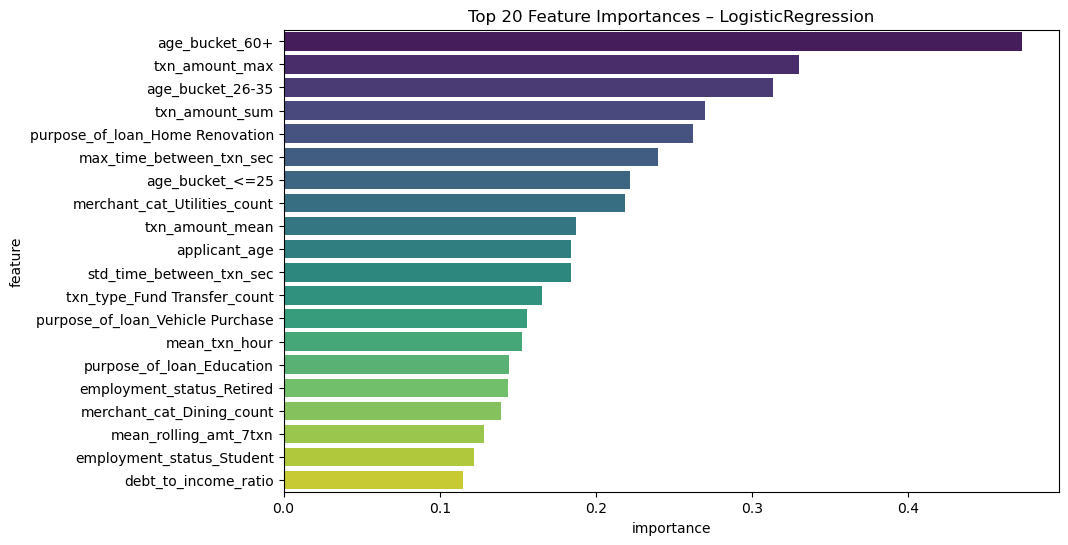


---- RandomForest: Top 20 Features ----


/var/folders/nt/lksf3v5916q60xttk_z7182m0000gn/T/ipykernel_46113/3305877514.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top20, palette="viridis")


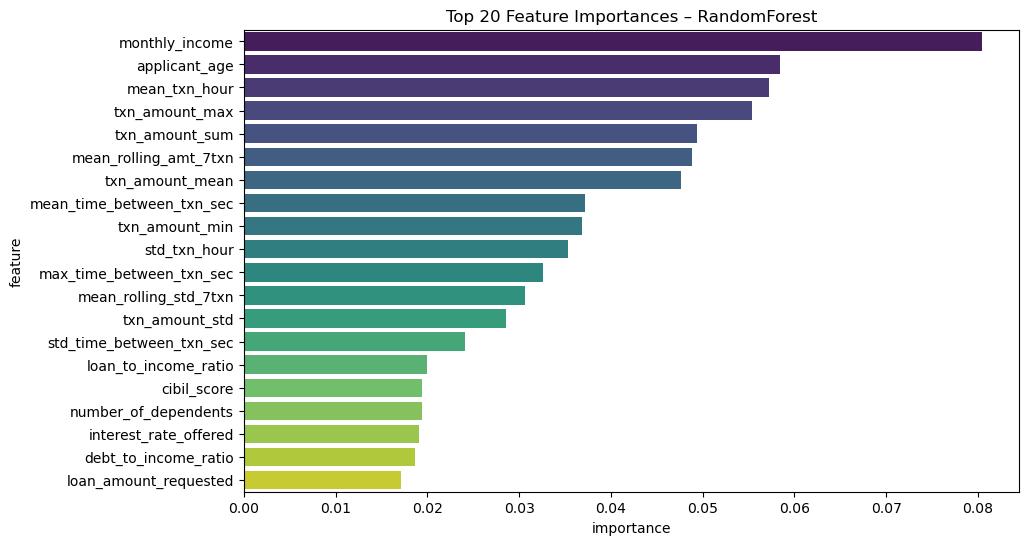


---- XGBoost: Top 20 Features ----


/var/folders/nt/lksf3v5916q60xttk_z7182m0000gn/T/ipykernel_46113/3305877514.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top20, palette="viridis")


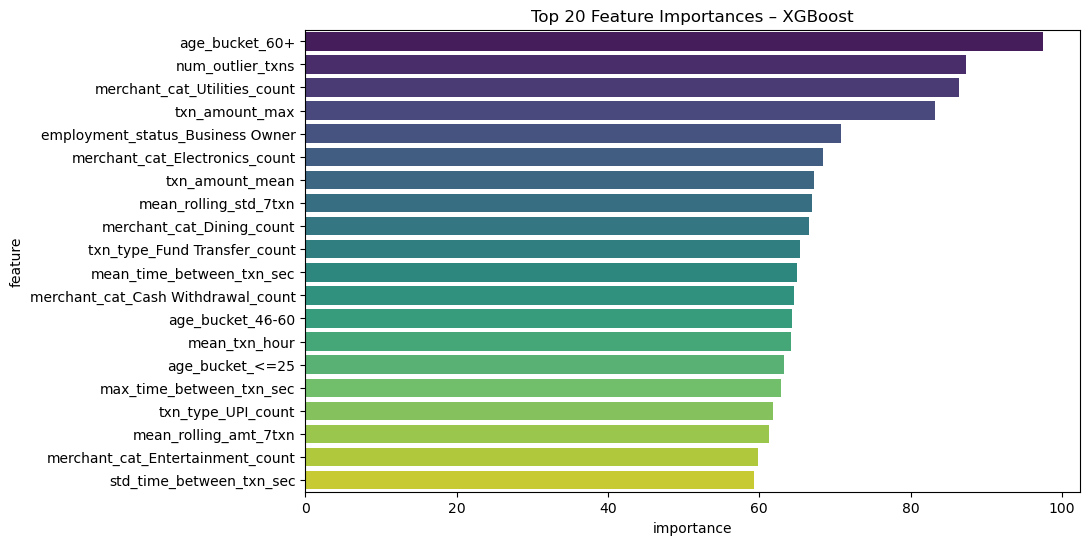

In [ ]:
model_importances = {}

# Iterate through all models to generate comparative feature importance analysis
for model_name, base_clf in models.items():
    clf_temp = Pipeline(steps=[("preprocess", preprocessor), ("model", base_clf)])
    clf_temp.fit(X, y)
    
    pre = clf_temp.named_steps["preprocess"]
    feature_names = get_feature_names(pre)
    model_step = clf_temp.named_steps["model"]
    
    if isinstance(model_step, RandomForestClassifier):
        importances = model_step.feature_importances_
    elif isinstance(model_step, LogisticRegression):
        importances = np.abs(model_step.coef_[0])
    elif isinstance(model_step, XGBClassifier):
        booster = model_step.get_booster()
        score_dict = booster.get_score(importance_type="gain")
        xgb_names = [f"f{i}" for i in range(len(feature_names))]
        importances = np.array([score_dict.get(name, 0.0) for name in xgb_names])
    else:
        continue

    df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    model_importances[model_name] = df
    
    # Plot individual model importance
    print(f"\n---- {model_name}: Top 20 Features ----")
    top20 = df.head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=top20, palette="viridis")
    plt.title(f"Top 20 Feature Importances – {model_name}")
    plt.show()


=== Aggregated Top 20 Features ===


,feature,LogisticRegression_importance,RandomForest_importance,XGBoost_importance,avg_importance
59,txn_amount_max,0.046972,0.055409,0.023144,0.041841
63,txn_amount_sum,0.038372,0.049327,0.016407,0.034702
44,monthly_income,0.005698,0.080416,0.016434,0.034183
5,applicant_age,0.026199,0.058456,0.015213,0.033289
31,mean_txn_hour,0.021741,0.057259,0.017824,0.032275
3,age_bucket_60+,0.067267,0.002094,0.027110,0.032157
60,txn_amount_mean,0.026661,0.047593,0.018675,0.030976
27,max_time_between_txn_sec,0.034167,0.032635,0.017457,0.028087
28,mean_rolling_amt_7txn,0.018234,0.048855,0.017029,0.028039
57,std_time_between_txn_sec,0.026171,0.024082,0.016473,0.022242


/var/folders/nt/lksf3v5916q60xttk_z7182m0000gn/T/ipykernel_46113/4224788382.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_importance", y="feature", data=agg_top20, palette="magma")


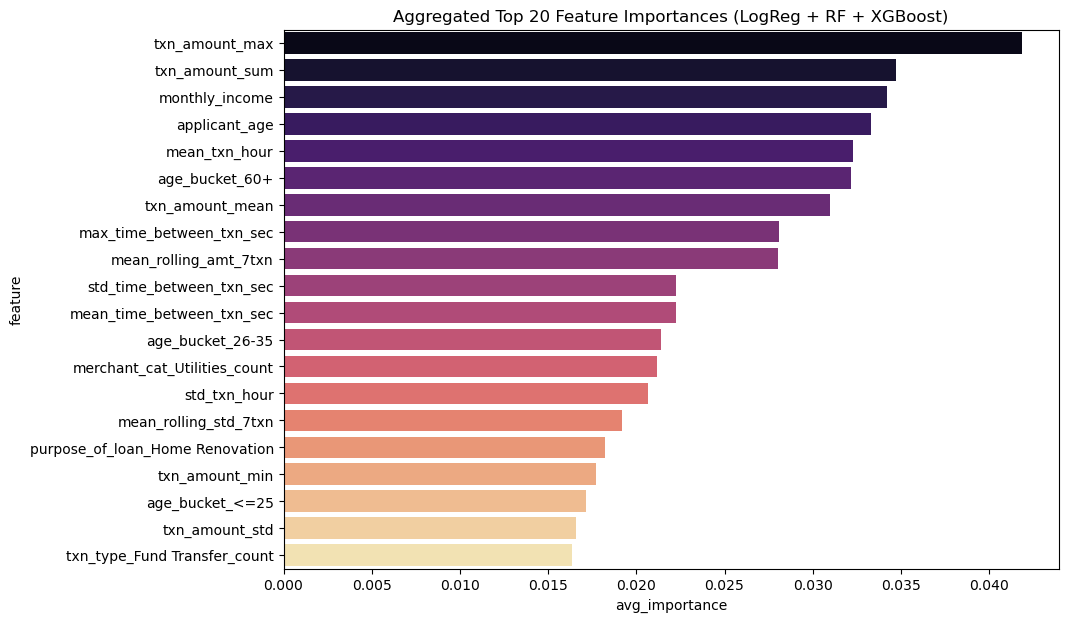

In [ ]:
# Aggregated Importance
agg_df = None
for model_name, df in model_importances.items():
    temp = df.copy()
    temp["importance"] = temp["importance"] / temp["importance"].sum() # Normalize
    temp = temp.rename(columns={"importance": f"{model_name}_importance"})
    if agg_df is None:
        agg_df = temp
    else:
        agg_df = agg_df.merge(temp, on="feature", how="outer")

agg_df = agg_df.fillna(0)
importance_cols = [c for c in agg_df.columns if c.endswith("_importance")]
agg_df["avg_importance"] = agg_df[importance_cols].mean(axis=1)
agg_top20 = agg_df.sort_values("avg_importance", ascending=False).head(20)

print("\n=== Aggregated Top 20 Features ===")
display(agg_top20)

plt.figure(figsize=(10, 7))
sns.barplot(x="avg_importance", y="feature", data=agg_top20, palette="magma")
plt.title("Aggregated Top 20 Feature Importances (LogReg + RF + XGBoost)")
plt.show()